# GIS Project - 서울시 건물물리정보 기반 GEO-SOM 클러스터링 및 K-Means 재군집화

본 프로젝트는 서울시 용도별 건물 데이터를 활용하여, 건축물의 물리적 특성(용적률, 건폐율, 높이, 총 층수, 건물 나이)을 기반으로  
도시 공간을 **데이터 중심의 새로운 관점**에서 군집화하는 것을 목표로 한다.  

먼저 GEO-SOM(Self-Organizing Map) 알고리즘을 사용하여 각 건물을 고차원 공간에서 유사 특성을 지닌 클러스터로 분류하였다.  
이후, 클러스터가 할당된 개별 건물 포인트를 바탕으로 보로노이(Voronoi) 폴리곤을 생성하여,  
공간적 군집 구조를 시각화하고 직관적으로 이해할 수 있는 형태로 표현하였다.  

그러나 GEO-SOM 결과는 클러스터 수가 많고 분산되어 해석이 어려운 한계가 있어,  
2차적으로 K-Means 알고리즘을 적용하였다.  
건물 위치 좌표(x, y)와 GEO-SOM 클러스터 중심 좌표(x′, y′)를 결합한 4차원 벡터를 기반으로 군집을 재구성하였고,  
Gap Statistic을 활용하여 최적의 군집 수를 결정함으로써 공간적으로 응집력 있고 해석 가능한 결과를 도출하였다.  

이 분석은 전통적인 인구통계 기반 접근과 달리, **건축물 물리 정보 중심의 도시 구조 이해**를 가능케 하며,  
향후 도시계획, 재개발, 환경 개선 등 다양한 분야에 실용적인 인사이트를 제공할 수 있다.


분석 배경 및 목표

기존의 서울시 공간 군집 분석은 대부분 인구, 소득, 연령 등 인구사회학적 데이터를 기반으로 이루어졌으며, 그 결과로 강남3구(강남, 서초, 송파), 강북지역, 영등포 등과 같이 이미 널리 알려진 공간 클러스터들이 반복적으로 등장하는 경향이 있습니다.하지만 우리는 **서울을 물리적인 건축 환경의 관점에서 새롭게 바라볼 수는 없을까?**라는 문제의식에서 출발하였습니다.따라서 이번 프로젝트의 목적은 서울시의 건물정보를 기반으로 공간 군집을 시도함으로써, 물리적 도시구조의 패턴을 발견하고 이를 해석하는 것입니다.

이는 “Let data speak for themselves” (Gould 1981) 라는 원칙 아래, 선입견 없는 데이터 중심의 도시 정책 접근을 모색하려는 시도의 일환입니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

In [ ]:
import sys

util = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/'
sys.path.append(util)
from utils import *

In [ ]:
path = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/data'

In [ ]:
# 동대문구 건물 shp파일
#/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11230_20250115/AL_D198_11230_20250115.shp

In [ ]:
# 동대문구 건물
dongDea_gdf = gpd.read_file(os.path.join(path,'AL_D198_11230_20250115/AL_D198_11230_20250115.shp'), encoding='euc-kr')

#데이터 불러오기

<Axes: >

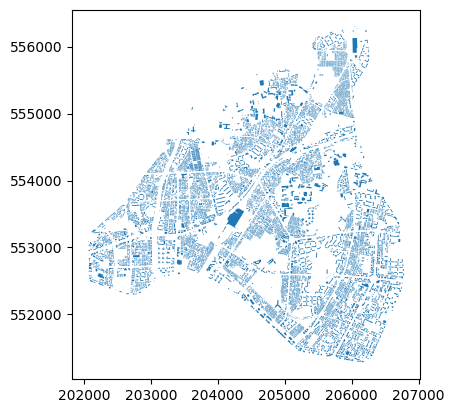

In [ ]:
dongDea_gdf.plot()

In [ ]:
dongDea_gdf.shape

(19541, 37)

In [ ]:
path2 = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/data2/hoegiDong'

In [ ]:
hoeGi_gdf = gpd.read_file(os.path.join(path2,'hoegi.shp'), encoding = 'euc-kr')

In [ ]:
dongDea_gdf.crs

<Projected CRS: EPSG:5186>
Name: KGD2002 / Central Belt 2010
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore between 126°E and 128°E.
- bounds: (126.0, 33.14, 128.0, 38.33)
Coordinate Operation:
- name: Korea Central Belt 2010
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
hoeGi_gdf.crs

<Projected CRS: EPSG:5179>
Name: KGD2002 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
# 동대문구 건물 좌표계: EPSG 5186
# 회기동 법정동 경계: EPSG 5179

dongDea_gdf = dongDea_gdf.to_crs('epsg:5179')

In [ ]:
# 동대문구 건물 데이터에서 회기동만 추출 (clip으로 찍어냄)
hoeGi_buildings = gpd.clip(dongDea_gdf,hoeGi_gdf)

<Axes: >

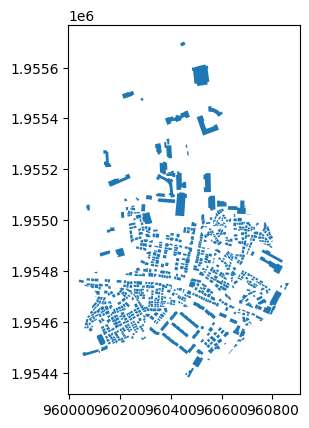

In [ ]:
hoeGi_buildings.plot()

In [ ]:
# centroid 좌표로 geometry를 변환한 GeoDataFrame 생성
hoeGi_buildings_centroid = hoeGi_buildings.copy()
hoeGi_buildings_centroid['geometry'] = hoeGi_buildings_centroid.geometry.centroid


<Axes: >

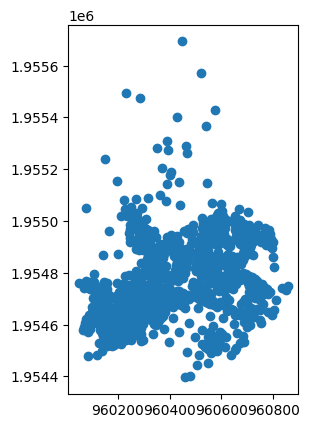

In [ ]:
hoeGi_buildings_centroid.plot()

# 데이터 전처리

데이터 및 변수

분석에는 **서울시의 용도별 건물정보 데이터 (shapefile)**를 활용하였으며, 이 데이터에는 각 건물의 위치와 속성이 포함되어 있습니다.

사용된 주요 변수 (5개 벡터):

용적률 (Floor Area Ratio)

건폐율 (Building Coverage Ratio)

건물 높이 (in meters)

총 층수 (지상 + 지하)

건물 나이 (2025년 기준 승인일자로부터 경과한 연수)

Select Which Features (Vectors) Would Influence Our Research

Geo-SOM 알고리즘은 각 feature가 output node에 완전히 연결되는 구조를 갖는다.따라서 feature가 하나 추가될 때마다, 하나의 epoch 내에서 수행되는 연산이 PxQ만큼 증가하게 된다.

이번 연구는 CBD, GBD, YBD와 같이 기존 인구사회학적 특성이 반영된 클러스터링과는 달리,데이터 기반의 새로운 공간 분류를 지향한다.이에 따라 건물의 물리적·객관적 특성만을 고려하여 feature를 선택하는 것이 핵심이다.이는 분석의 순수성을 확보하고, 의미 있는 클러스터링 결과를 도출하는 데 기여할 것이다.

In [ ]:
hoeGi_point = hoeGi_buildings_centroid.loc[:,['A20','A21','A30','A31','A32','A34','geometry']]
# A31은 지상층수, A32는 지하층수이다. 따라서, 전체 층수는 이 둘을 합한 값으로 사용한다.
hoeGi_point['total_floor'] = hoeGi_point['A31'] + hoeGi_point['A32']
hoeGi_point = hoeGi_point.loc[:,['A20','A21','A30','A34','total_floor','geometry']]
hoeGi_point.dropna(inplace=True)

In [ ]:
# 데이터의 사용승인일자 column에 1970년 이전 값은 판다스의 [datetime]형에서 사용할 수 없음
# 따라서, 1970년 이전 값은 모두 1970년 1월 1일 기준으로 처리
for idx, row in hoeGi_point.iterrows():
  x = int(row.values[3][:4])
  if x < 1970:
    hoeGi_point.at[idx,'A34'] = '1970-01-01'

In [ ]:
hoeGi_point.dropna(inplace=True)

In [ ]:
# 형변환
hoeGi_point['A34'] = pd.to_datetime(hoeGi_point['A34'])
# 기준일: 2025년 1월 1일
reference_date = pd.to_datetime('2025-01-01')
hoeGi_point['years_old'] = (reference_date - hoeGi_point['A34']).dt.days // 365
hoeGi_point.drop(columns=['A34'],inplace=True)

표준화를 통하여 특정 column의 영향만 커지는 것을 막고

In [ ]:
# 표준화를 진행
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
hoeGi_point[['A20', 'A21', 'A30', 'total_floor', 'years_old']] = scaler.fit_transform(hoeGi_point[['A20', 'A21', 'A30', 'total_floor', 'years_old']])

정규화를 통하여 모델의 과적합을 방지

In [ ]:
# 정규화를 진행
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hoeGi_point[['A20', 'A21', 'A30', 'total_floor', 'years_old']] = scaler.fit_transform(hoeGi_point[['A20', 'A21', 'A30', 'total_floor', 'years_old']])

#알고리즘

1차 군집 분석: GEO-SOM

첫 번째 군집화 방법으로는 GEO-SOM (Geographically Weighted Self-Organizing Map) 알고리즘을 사용했습니다.

20x20 grid를 구성하여 데이터를 학습시켰으며,

각 건물은 GEO-SOM에 의해 특정 클러스터로 할당되었습니다.

이후, 각 건물을 포인트로 시각화하고, 해당 포인트들을 기반으로 **보로노이 다이어그램(Voronoi Polygon)**을 생성하였습니다.

보로노이 면적의 각 셀에는 해당하는 클러스터 번호를 할당하여 공간적인 군집지도를 구성하였습니다.

문제점 발견:

GEO-SOM의 특성상 군집의 수가 많고 공간적으로 분산되는 현상이 나타남

시각적으로도 해석이 어려울 정도로 세분화된 결과가 나와서 추가적인 군집 압축이 필요하다는 판단

Training GeoSOM: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


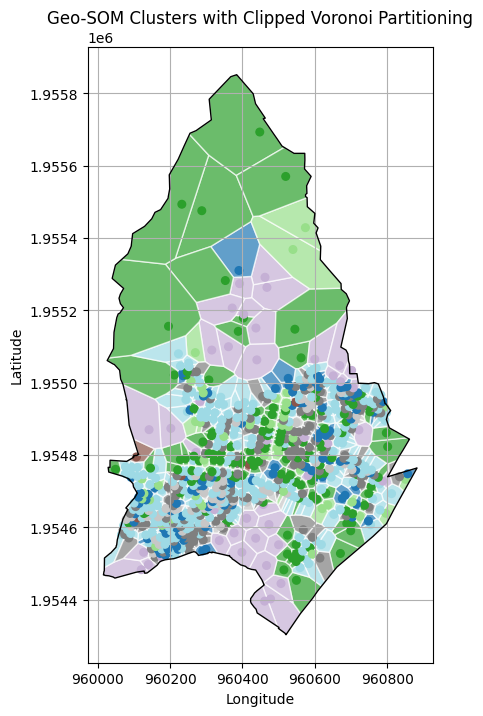

In [ ]:
# ====== 메인 실행 ======
if __name__ == "__main__":
    # 1. 포인트 준비
    X_geo = hoeGi_point.geometry.apply(lambda geom: [geom.x, geom.y]).tolist()
    X_geo = np.array(X_geo)
    X_ngf = hoeGi_point[['A20', 'A21', 'A30', 'total_floor', 'years_old']].values

    # 2. GeoSOM 모델 학습
    model = GeoSOM(grid_shape=(20, 20), geo_tolerance=4, input_dim=X_ngf.shape[1], fixed_geo=True)
    model.train(X_geo, X_ngf, epochs=50)

    # 3. 클러스터 할당
    assignments = model.get_cluster_assignments(X_geo, X_ngf)

    # 4. Voronoi 폴리곤 생성 (유한/무한경계 모두 처리)
    polygons, vor = construct_voronoi_polygons(X_geo)

    # 5. Voronoi를 GeoDataFrame으로 변환
    gdf_voronoi = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=polygons, crs='EPSG:5179')  # 좌표계

    # 6. hoegi_gdf 기준으로 Clip
    gdf_voronoi_clipped = gpd.clip(gdf_voronoi, hoeGi_gdf)

    # 7. 포인트도 GeoDataFrame으로 변환
    points = [Point(x, y) for x, y in X_geo]
    gdf_points = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=points)

    # 8. 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    hoeGi_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    gdf_voronoi_clipped.plot(column='cluster', cmap='tab20', edgecolor='white', alpha=0.7, ax=ax)
    gdf_points.plot(column='cluster', cmap='tab20', markersize=30, ax=ax)
    plt.title('Geo-SOM Clusters with Clipped Voronoi Partitioning')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

In [ ]:
gdf_voronoi_clipped.crs

<Projected CRS: EPSG:5179>
Name: KGD2002 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
gdf_voronoi_clipped['cluster'].unique()

array([357, 337, 339, 338, 397, 319, 395, 396, 398, 378, 376, 377, 399,
       379, 358, 359, 356])

2차 군집 분석: K-Means + Gap Statistic

위 문제를 해결하기 위해 두 번째 군집화 단계로는 K-Means 알고리즘을 적용하였습니다.

K-Means는 유클리디언 거리 기반 알고리즘으로, 일반적으로 이상치에 민감하지만,서울시 내 건물 데이터는 극단적인 이상치가 적고 분포가 제한적이므로 K-Means 적용이 타당하다고 판단하였습니다.

클러스터링 입력:

각 건물 포인트의 좌표 (x, y)

GEO-SOM을 통해 할당된 클러스터의 중심좌표 (x’, y’)→ 총 4차원의 좌표 정보를 바탕으로 K-Means 클러스터링 수행

군집 수 결정:

Gap Statistic 기법을 사용하여 최적의 군집 수를 탐색하고 적용

결과:

GEO-SOM의 세분화된 군집을 K-Means를 통해 공간적으로 응집력 있는 군집들로 재구성

시각적으로 해석이 용이하며, 건물 물리정보 기반의 서울시 패턴을 효과적으로 요약 가능

In [ ]:
for i in range(len(gdf_voronoi_clipped['cluster'].unique())):
  condition_01 = gdf_voronoi_clipped['cluster'] == gdf_voronoi_clipped['cluster'].unique()[i]
  x01 = gdf_voronoi_clipped[condition_01]['geometry'].centroid.x.mean()
  y01 = gdf_voronoi_clipped[condition_01]['geometry'].centroid.y.mean()

  gdf_voronoi_clipped.loc[condition_01,'x01'] = x01
  gdf_voronoi_clipped.loc[condition_01,'y01'] = y01


In [ ]:
gdf_voronoi_clipped['x'] = gdf_voronoi_clipped.centroid.x
gdf_voronoi_clipped['y'] = gdf_voronoi_clipped.centroid.y

In [ ]:
X = gdf_voronoi_clipped[['x', 'y', 'x01', 'y01']].values

In [ ]:
k, gapdf = optimalK(X,maxClusters=15)
print('Optimal k is: ', k)

/content/drive/MyDrive/GIS_Project_GEO_SOM조/utils.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsdf = pd.concat([resultsdf, new_row], ignore_index=True)


Optimal k is:  10


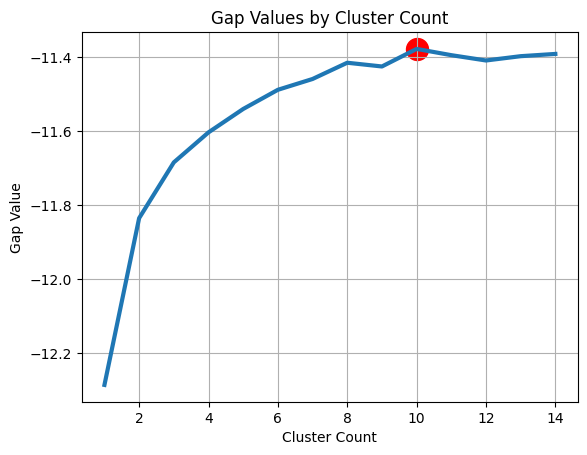

In [ ]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
gdf_voronoi_clipped['merged_cluster'] = kmeans.fit_predict(X)

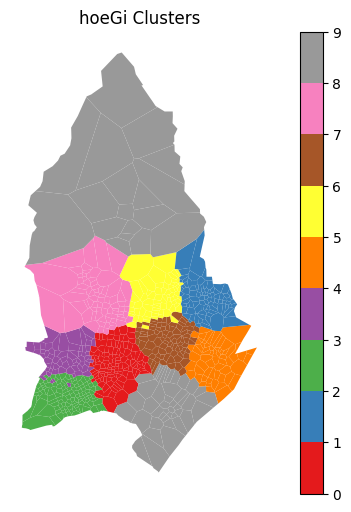

In [ ]:
gdf_voronoi_clipped.plot(column='merged_cluster', cmap='Set1', legend=True, figsize=(8,6))
plt.title("hoeGi Clusters")
plt.axis('off')
plt.show()